## Part II: PyTorch CNN (30 points)

In the second part of this assignment you will try to improve your neural architecture by using convolutional neural
networks (CNNs). You will use again the CIFAR10 dataset but this time you will implement a CNN to classify the
images in the dataset.

## 2.1 Task 1
Implement the CNN architecture and the training procedure by completing the files cnn model.py and cnn train.py.
The architecture of the network you need to create is detailed in the slides at the end of the CNN lecture (the
lecture of week 8) and it’s a reduced version of the well-known VGG network.

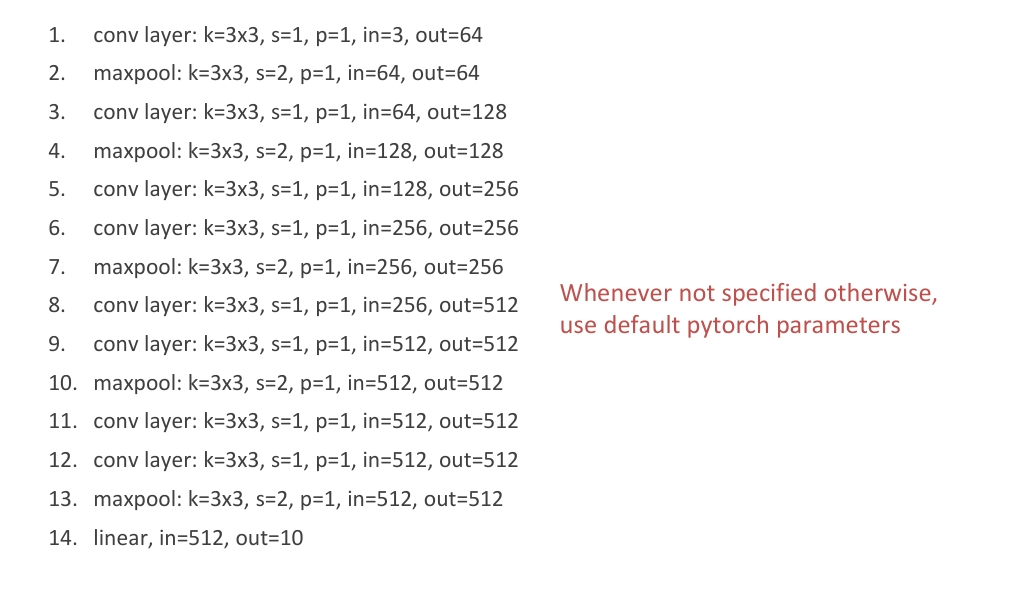

In [ ]:

import torch
import torch.nn as nn
class CNN(nn.Module):
  def __init__(self, n_channels, n_classes):
    """
    Initializes CNN object. 
    
    Args:
      n_channels: number of input channels
      n_classes: number of classes of the classification problem
    """
    super(CNN,self).__init__()
    self.n_classes=n_classes
    self.n_channels=n_channels
    self.sequential=nn.Sequential(
        nn.Conv2d(in_channels=n_channels,out_channels=64,kernel_size=3,padding=1,stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
        nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
        nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
        nn.Flatten(),
        nn.Linear(in_features=512,out_features=10),
    )
  def forward(self, x):
    """
    Performs forward pass of the input.
    
    Args:
      x: input to the network
    Returns:
      out: outputs of the network
    """
    out=self.sequential(x)
    return out


## 2.2 Task 2
Analyse the performance of the model by plotting accuracy and loss curves in a Jupyter notebook. To this end,
use the Adam optimizer with default learning rate and default PyTorch parameters to initialize convolutional and
linear layers. To compute the gradient, use mini-batch gradient descent.

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

def load_cifar10_vgg(batch_size=128, root='./data', num_workers=2):

    transform = transforms.ToTensor()
    train_val_set = datasets.CIFAR10(root=root, train=True,
                                     download=True, transform=transform)
    test_set = datasets.CIFAR10(root=root, train=False,
                                download=True, transform=transform)
    # 80 % / 20 % 划分
    train_size = int(0.8 * len(train_val_set))
    val_size   = len(train_val_set) - train_size
    train_data, val_data = random_split(
        train_val_set, [train_size, val_size],
        generator=torch.Generator().manual_seed(42))
    # DataLoader
    train_loader = DataLoader(train_data, batch_size=batch_size,
                              shuffle=True,  num_workers=num_workers,
                              pin_memory=True)
    val_loader   = DataLoader(val_data,   batch_size=batch_size,
                              shuffle=False, num_workers=num_workers,
                              pin_memory=True)
    test_loader  = DataLoader(test_set,   batch_size=batch_size,
                              shuffle=False, num_workers=num_workers,
                              pin_memory=True)

    return train_loader, val_loader, test_loader

In [ ]:
train_loader, val_loader, test_loader = load_cifar10_vgg(batch_size=32)
print(f'Train batches: {len(train_loader)}  '
      f'Val batches: {len(val_loader)}  '
      f'Test batches: {len(test_loader)}')

Train batches: 1250  Val batches: 313  Test batches: 313


In [ ]:

from tqdm import tqdm
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    """
    训练一个 epoch
    """
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total=0
    for x, y in train_loader:
        x,y=x.to(device),y.to(device)
        optimizer.zero_grad()
        logits=model(x)
        loss=criterion(logits,y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        running_corrects += (logits.argmax(1) == y).sum().item()
        total+=x.size(0)
    return running_loss /total, running_corrects / total
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, running_correct, total = 0., 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        running_loss += loss.item() * x.size(0)
        running_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    avg_loss = running_loss / total
    avg_acc  = running_correct / total
    return avg_loss, avg_acc


In [ ]:
def train(model,train_loader, val_loader, optimizer, criterion, device, max_epochs=150, eval_freq=10):
    """
    训练模型，使用 accuracy 计算准确率
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    model.to(device)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in tqdm(range(max_epochs), desc='Epoch', position=0, leave=True):
        # 1. 训练
        train_loss, train_acc = train_one_epoch(model, train_loader,
                                                optimizer, criterion, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # 2. 验证
        if (epoch + 1) % eval_freq == 0 or epoch == max_epochs - 1:
            val_loss, val_acc = evaluate(model, val_loader, criterion, device)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            print(f'Epoch {epoch+1}/{max_epochs}, '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    return {'train_loss': train_losses,
            'train_acc':  train_accuracies,
            'val_loss':   val_losses,
            'val_acc':    val_accuracies}

import matplotlib.pyplot as plt
def plot_curve(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history['train_loss'], label='Train Loss', color='tab:red')
    plt.plot(history['val_loss'],   label='Val Loss',  color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2. 准确率曲线
    plt.figure(figsize=(6, 4))
    plt.plot(history['train_acc'], label='Train Acc', color='tab:red')
    plt.plot(history['val_acc'],   label='Val Acc',  color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Using device: cuda


Epoch:   1%|          | 1/150 [00:27<1:08:13, 27.47s/it]

Epoch 1/150, Train Loss: 1.9213, Train Acc: 0.2349, Val Loss: 1.7116, Val Acc: 0.3012


Epoch:   1%|▏         | 2/150 [01:05<1:23:22, 33.80s/it]

Epoch 2/150, Train Loss: 1.6125, Train Acc: 0.3602, Val Loss: 1.4945, Val Acc: 0.4346


Epoch:   2%|▏         | 3/150 [01:43<1:27:12, 35.60s/it]

Epoch 3/150, Train Loss: 1.4167, Train Acc: 0.4648, Val Loss: 1.3817, Val Acc: 0.4918


Epoch:   3%|▎         | 4/150 [02:20<1:28:22, 36.32s/it]

Epoch 4/150, Train Loss: 1.2617, Train Acc: 0.5369, Val Loss: 1.2808, Val Acc: 0.5340


Epoch:   3%|▎         | 5/150 [02:56<1:27:23, 36.16s/it]

Epoch 5/150, Train Loss: 1.1333, Train Acc: 0.5928, Val Loss: 1.1421, Val Acc: 0.5904


Epoch:   4%|▍         | 6/150 [03:21<1:17:26, 32.27s/it]

Epoch 6/150, Train Loss: 1.0244, Train Acc: 0.6351, Val Loss: 1.1257, Val Acc: 0.6025


Epoch:   5%|▍         | 7/150 [03:43<1:09:03, 28.98s/it]

Epoch 7/150, Train Loss: 0.9266, Train Acc: 0.6696, Val Loss: 1.0361, Val Acc: 0.6341


Epoch:   5%|▌         | 8/150 [04:07<1:04:24, 27.22s/it]

Epoch 8/150, Train Loss: 0.8403, Train Acc: 0.7029, Val Loss: 1.0264, Val Acc: 0.6459


Epoch:   6%|▌         | 9/150 [04:29<1:00:21, 25.69s/it]

Epoch 9/150, Train Loss: 0.7621, Train Acc: 0.7307, Val Loss: 1.0006, Val Acc: 0.6636


Epoch:   7%|▋         | 10/150 [04:51<57:25, 24.61s/it] 

Epoch 10/150, Train Loss: 0.6765, Train Acc: 0.7600, Val Loss: 1.0323, Val Acc: 0.6589


Epoch:   7%|▋         | 11/150 [05:14<55:36, 24.00s/it]

Epoch 11/150, Train Loss: 0.5968, Train Acc: 0.7922, Val Loss: 1.0420, Val Acc: 0.6685


Epoch:   8%|▊         | 12/150 [05:37<54:21, 23.63s/it]

Epoch 12/150, Train Loss: 0.5186, Train Acc: 0.8167, Val Loss: 1.0394, Val Acc: 0.6751


Epoch:   9%|▊         | 13/150 [05:59<53:06, 23.26s/it]

Epoch 13/150, Train Loss: 0.4460, Train Acc: 0.8420, Val Loss: 1.1047, Val Acc: 0.6814


Epoch:   9%|▉         | 14/150 [06:21<52:07, 23.00s/it]

Epoch 14/150, Train Loss: 0.3761, Train Acc: 0.8682, Val Loss: 1.2495, Val Acc: 0.6660


Epoch:  10%|█         | 15/150 [06:45<51:59, 23.11s/it]

Epoch 15/150, Train Loss: 0.3180, Train Acc: 0.8883, Val Loss: 1.2457, Val Acc: 0.6725


Epoch:  11%|█         | 16/150 [07:16<57:04, 25.56s/it]

Epoch 16/150, Train Loss: 0.2776, Train Acc: 0.9008, Val Loss: 1.2812, Val Acc: 0.6793


Epoch:  11%|█▏        | 17/150 [07:39<54:48, 24.73s/it]

Epoch 17/150, Train Loss: 0.2404, Train Acc: 0.9152, Val Loss: 1.4295, Val Acc: 0.6795


Epoch:  12%|█▏        | 18/150 [08:07<56:59, 25.91s/it]

Epoch 18/150, Train Loss: 0.1974, Train Acc: 0.9313, Val Loss: 1.4684, Val Acc: 0.6711


Epoch:  13%|█▎        | 19/150 [08:42<1:02:31, 28.64s/it]

Epoch 19/150, Train Loss: 0.1799, Train Acc: 0.9372, Val Loss: 1.5294, Val Acc: 0.6716


Epoch:  13%|█▎        | 20/150 [09:05<57:58, 26.76s/it]  

Epoch 20/150, Train Loss: 0.1572, Train Acc: 0.9457, Val Loss: 1.5128, Val Acc: 0.6723


Epoch:  14%|█▍        | 21/150 [09:27<54:53, 25.53s/it]

Epoch 21/150, Train Loss: 0.1457, Train Acc: 0.9500, Val Loss: 1.6748, Val Acc: 0.6800


Epoch:  15%|█▍        | 22/150 [09:51<53:00, 24.85s/it]

Epoch 22/150, Train Loss: 0.1307, Train Acc: 0.9548, Val Loss: 1.7621, Val Acc: 0.6667


Epoch:  15%|█▌        | 23/150 [10:14<51:35, 24.38s/it]

Epoch 23/150, Train Loss: 0.1209, Train Acc: 0.9583, Val Loss: 1.7713, Val Acc: 0.6745


Epoch:  16%|█▌        | 24/150 [10:36<49:42, 23.67s/it]

Epoch 24/150, Train Loss: 0.1163, Train Acc: 0.9596, Val Loss: 1.8039, Val Acc: 0.6878


Epoch:  17%|█▋        | 25/150 [10:58<48:33, 23.31s/it]

Epoch 25/150, Train Loss: 0.1043, Train Acc: 0.9643, Val Loss: 1.8379, Val Acc: 0.6810


Epoch:  17%|█▋        | 26/150 [11:21<47:41, 23.08s/it]

Epoch 26/150, Train Loss: 0.0991, Train Acc: 0.9660, Val Loss: 1.7450, Val Acc: 0.6763


Epoch:  18%|█▊        | 27/150 [11:43<46:23, 22.63s/it]

Epoch 27/150, Train Loss: 0.0943, Train Acc: 0.9679, Val Loss: 1.8349, Val Acc: 0.6903


Epoch:  19%|█▊        | 28/150 [12:04<45:23, 22.32s/it]

Epoch 28/150, Train Loss: 0.0845, Train Acc: 0.9714, Val Loss: 1.9713, Val Acc: 0.6727


Epoch:  19%|█▉        | 29/150 [12:26<44:34, 22.10s/it]

Epoch 29/150, Train Loss: 0.0867, Train Acc: 0.9705, Val Loss: 1.9559, Val Acc: 0.6839


Epoch:  20%|██        | 30/150 [12:47<43:54, 21.95s/it]

Epoch 30/150, Train Loss: 0.0861, Train Acc: 0.9713, Val Loss: 1.8171, Val Acc: 0.6880


Epoch:  21%|██        | 31/150 [13:09<43:26, 21.90s/it]

Epoch 31/150, Train Loss: 0.0716, Train Acc: 0.9761, Val Loss: 1.9693, Val Acc: 0.6841


Epoch:  21%|██▏       | 32/150 [13:31<42:53, 21.81s/it]

Epoch 32/150, Train Loss: 0.0717, Train Acc: 0.9748, Val Loss: 1.9660, Val Acc: 0.6864


Epoch:  22%|██▏       | 33/150 [13:52<42:24, 21.75s/it]

Epoch 33/150, Train Loss: 0.0752, Train Acc: 0.9747, Val Loss: 1.8626, Val Acc: 0.6848


Epoch:  23%|██▎       | 34/150 [14:14<42:03, 21.75s/it]

Epoch 34/150, Train Loss: 0.0646, Train Acc: 0.9790, Val Loss: 1.9511, Val Acc: 0.6889


Epoch:  23%|██▎       | 35/150 [14:36<41:35, 21.70s/it]

Epoch 35/150, Train Loss: 0.0659, Train Acc: 0.9781, Val Loss: 1.9800, Val Acc: 0.6765


Epoch:  24%|██▍       | 36/150 [14:57<41:10, 21.67s/it]

Epoch 36/150, Train Loss: 0.0701, Train Acc: 0.9770, Val Loss: 1.8919, Val Acc: 0.6829


Epoch:  25%|██▍       | 37/150 [15:19<40:53, 21.71s/it]

Epoch 37/150, Train Loss: 0.0584, Train Acc: 0.9808, Val Loss: 1.9010, Val Acc: 0.6896


Epoch:  25%|██▌       | 38/150 [15:52<46:57, 25.16s/it]

Epoch 38/150, Train Loss: 0.0617, Train Acc: 0.9796, Val Loss: 2.0567, Val Acc: 0.6853


Epoch:  26%|██▌       | 39/150 [16:21<48:39, 26.30s/it]

Epoch 39/150, Train Loss: 0.0571, Train Acc: 0.9816, Val Loss: 1.9516, Val Acc: 0.6881


Epoch:  27%|██▋       | 40/150 [16:49<49:14, 26.86s/it]

Epoch 40/150, Train Loss: 0.0562, Train Acc: 0.9807, Val Loss: 1.7992, Val Acc: 0.6910


Epoch:  27%|██▋       | 41/150 [17:17<49:17, 27.14s/it]

Epoch 41/150, Train Loss: 0.0527, Train Acc: 0.9823, Val Loss: 2.0750, Val Acc: 0.6936


Epoch:  28%|██▊       | 42/150 [17:45<49:06, 27.28s/it]

Epoch 42/150, Train Loss: 0.0569, Train Acc: 0.9799, Val Loss: 2.0389, Val Acc: 0.6883


Epoch:  29%|██▊       | 43/150 [18:11<48:01, 26.93s/it]

Epoch 43/150, Train Loss: 0.0518, Train Acc: 0.9829, Val Loss: 1.9255, Val Acc: 0.6938


Epoch:  29%|██▉       | 44/150 [18:36<46:20, 26.23s/it]

Epoch 44/150, Train Loss: 0.0495, Train Acc: 0.9831, Val Loss: 2.0103, Val Acc: 0.6923


Epoch:  30%|███       | 45/150 [19:02<45:54, 26.23s/it]

Epoch 45/150, Train Loss: 0.0511, Train Acc: 0.9827, Val Loss: 2.0600, Val Acc: 0.6813


Epoch:  31%|███       | 46/150 [19:26<44:33, 25.71s/it]

Epoch 46/150, Train Loss: 0.0426, Train Acc: 0.9855, Val Loss: 2.0238, Val Acc: 0.6900


Epoch:  31%|███▏      | 47/150 [19:51<43:22, 25.27s/it]

Epoch 47/150, Train Loss: 0.0491, Train Acc: 0.9838, Val Loss: 2.2066, Val Acc: 0.6855


Epoch:  32%|███▏      | 48/150 [20:15<42:37, 25.07s/it]

Epoch 48/150, Train Loss: 0.0452, Train Acc: 0.9844, Val Loss: 2.2327, Val Acc: 0.6935


Epoch:  33%|███▎      | 49/150 [20:39<41:50, 24.85s/it]

Epoch 49/150, Train Loss: 0.0431, Train Acc: 0.9862, Val Loss: 2.2194, Val Acc: 0.6772


Epoch:  33%|███▎      | 50/150 [21:04<41:14, 24.74s/it]

Epoch 50/150, Train Loss: 0.0464, Train Acc: 0.9844, Val Loss: 1.9411, Val Acc: 0.7025


Epoch:  34%|███▍      | 51/150 [21:28<40:42, 24.67s/it]

Epoch 51/150, Train Loss: 0.0395, Train Acc: 0.9874, Val Loss: 2.0906, Val Acc: 0.6909


Epoch:  35%|███▍      | 52/150 [21:53<40:12, 24.62s/it]

Epoch 52/150, Train Loss: 0.0439, Train Acc: 0.9853, Val Loss: 2.1574, Val Acc: 0.6927


Epoch:  35%|███▌      | 53/150 [22:17<39:40, 24.54s/it]

Epoch 53/150, Train Loss: 0.0402, Train Acc: 0.9864, Val Loss: 2.2694, Val Acc: 0.6862


Epoch:  36%|███▌      | 54/150 [22:42<39:10, 24.48s/it]

Epoch 54/150, Train Loss: 0.0404, Train Acc: 0.9875, Val Loss: 2.0353, Val Acc: 0.6820


Epoch:  37%|███▋      | 55/150 [23:06<38:43, 24.46s/it]

Epoch 55/150, Train Loss: 0.0386, Train Acc: 0.9874, Val Loss: 2.0767, Val Acc: 0.6981


Epoch:  37%|███▋      | 56/150 [23:30<38:17, 24.44s/it]

Epoch 56/150, Train Loss: 0.0367, Train Acc: 0.9884, Val Loss: 2.1328, Val Acc: 0.6968


Epoch:  38%|███▊      | 57/150 [23:55<37:50, 24.42s/it]

Epoch 57/150, Train Loss: 0.0387, Train Acc: 0.9868, Val Loss: 2.0807, Val Acc: 0.6981


Epoch:  39%|███▊      | 58/150 [24:20<37:37, 24.54s/it]

Epoch 58/150, Train Loss: 0.0344, Train Acc: 0.9888, Val Loss: 1.9835, Val Acc: 0.6937


Epoch:  39%|███▉      | 59/150 [24:45<37:25, 24.67s/it]

Epoch 59/150, Train Loss: 0.0341, Train Acc: 0.9888, Val Loss: 2.2953, Val Acc: 0.6933


Epoch:  40%|████      | 60/150 [25:10<37:13, 24.82s/it]

Epoch 60/150, Train Loss: 0.0358, Train Acc: 0.9881, Val Loss: 2.1796, Val Acc: 0.6967


Epoch:  41%|████      | 61/150 [25:35<36:53, 24.87s/it]

Epoch 61/150, Train Loss: 0.0374, Train Acc: 0.9873, Val Loss: 2.0801, Val Acc: 0.6872


Epoch:  41%|████▏     | 62/150 [25:59<36:23, 24.82s/it]

Epoch 62/150, Train Loss: 0.0338, Train Acc: 0.9891, Val Loss: 2.1319, Val Acc: 0.6962


Epoch:  42%|████▏     | 63/150 [26:25<36:07, 24.91s/it]

Epoch 63/150, Train Loss: 0.0332, Train Acc: 0.9890, Val Loss: 2.3405, Val Acc: 0.6914


Epoch:  43%|████▎     | 64/150 [26:49<35:34, 24.82s/it]

Epoch 64/150, Train Loss: 0.0315, Train Acc: 0.9893, Val Loss: 2.2716, Val Acc: 0.7059


Epoch:  43%|████▎     | 65/150 [27:14<35:03, 24.75s/it]

Epoch 65/150, Train Loss: 0.0315, Train Acc: 0.9894, Val Loss: 2.7564, Val Acc: 0.6712


Epoch:  44%|████▍     | 66/150 [27:38<34:34, 24.70s/it]

Epoch 66/150, Train Loss: 0.0349, Train Acc: 0.9887, Val Loss: 2.3857, Val Acc: 0.6992


Epoch:  45%|████▍     | 67/150 [28:03<34:01, 24.60s/it]

Epoch 67/150, Train Loss: 0.0313, Train Acc: 0.9898, Val Loss: 2.1877, Val Acc: 0.6919


Epoch:  45%|████▌     | 68/150 [28:27<33:31, 24.54s/it]

Epoch 68/150, Train Loss: 0.0294, Train Acc: 0.9905, Val Loss: 2.3607, Val Acc: 0.6895


Epoch:  46%|████▌     | 69/150 [28:52<33:04, 24.49s/it]

Epoch 69/150, Train Loss: 0.0299, Train Acc: 0.9900, Val Loss: 2.2710, Val Acc: 0.6940


Epoch:  47%|████▋     | 70/150 [29:16<32:46, 24.59s/it]

Epoch 70/150, Train Loss: 0.0288, Train Acc: 0.9906, Val Loss: 2.4714, Val Acc: 0.6855


Epoch:  47%|████▋     | 71/150 [29:41<32:27, 24.65s/it]

Epoch 71/150, Train Loss: 0.0296, Train Acc: 0.9898, Val Loss: 2.2080, Val Acc: 0.7027


Epoch:  48%|████▊     | 72/150 [30:06<32:11, 24.77s/it]

Epoch 72/150, Train Loss: 0.0279, Train Acc: 0.9912, Val Loss: 2.1934, Val Acc: 0.6935


Epoch:  49%|████▊     | 73/150 [30:31<31:46, 24.76s/it]

Epoch 73/150, Train Loss: 0.0275, Train Acc: 0.9912, Val Loss: 2.2249, Val Acc: 0.7005


Epoch:  49%|████▉     | 74/150 [30:56<31:36, 24.95s/it]

Epoch 74/150, Train Loss: 0.0296, Train Acc: 0.9900, Val Loss: 2.4379, Val Acc: 0.6950


Epoch:  50%|█████     | 75/150 [31:21<31:07, 24.89s/it]

Epoch 75/150, Train Loss: 0.0271, Train Acc: 0.9917, Val Loss: 2.4163, Val Acc: 0.6954


Epoch:  51%|█████     | 76/150 [31:46<30:36, 24.82s/it]

Epoch 76/150, Train Loss: 0.0255, Train Acc: 0.9920, Val Loss: 2.4429, Val Acc: 0.6900


Epoch:  51%|█████▏    | 77/150 [32:12<30:45, 25.28s/it]

Epoch 77/150, Train Loss: 0.0296, Train Acc: 0.9906, Val Loss: 2.3824, Val Acc: 0.6936


Epoch:  52%|█████▏    | 78/150 [32:37<30:06, 25.09s/it]

Epoch 78/150, Train Loss: 0.0271, Train Acc: 0.9909, Val Loss: 2.3295, Val Acc: 0.7032


Epoch:  53%|█████▎    | 79/150 [33:01<29:29, 24.93s/it]

Epoch 79/150, Train Loss: 0.0263, Train Acc: 0.9918, Val Loss: 2.2839, Val Acc: 0.6994


Epoch:  53%|█████▎    | 80/150 [33:26<29:01, 24.88s/it]

Epoch 80/150, Train Loss: 0.0245, Train Acc: 0.9918, Val Loss: 2.5664, Val Acc: 0.6851


Epoch:  54%|█████▍    | 81/150 [33:52<29:07, 25.32s/it]

Epoch 81/150, Train Loss: 0.0287, Train Acc: 0.9900, Val Loss: 2.4404, Val Acc: 0.6964


Epoch:  55%|█████▍    | 82/150 [34:19<29:10, 25.74s/it]

Epoch 82/150, Train Loss: 0.0224, Train Acc: 0.9927, Val Loss: 2.5276, Val Acc: 0.6883


Epoch:  55%|█████▌    | 83/150 [34:44<28:20, 25.37s/it]

Epoch 83/150, Train Loss: 0.0258, Train Acc: 0.9920, Val Loss: 2.4093, Val Acc: 0.6921


Epoch:  56%|█████▌    | 84/150 [35:09<27:48, 25.28s/it]

Epoch 84/150, Train Loss: 0.0244, Train Acc: 0.9922, Val Loss: 2.2524, Val Acc: 0.7035


Epoch:  57%|█████▋    | 85/150 [35:33<27:11, 25.10s/it]

Epoch 85/150, Train Loss: 0.0236, Train Acc: 0.9924, Val Loss: 2.5139, Val Acc: 0.7064


Epoch:  57%|█████▋    | 86/150 [35:58<26:45, 25.08s/it]

Epoch 86/150, Train Loss: 0.0268, Train Acc: 0.9923, Val Loss: 2.2640, Val Acc: 0.7004


Epoch:  58%|█████▊    | 87/150 [36:23<26:14, 24.99s/it]

Epoch 87/150, Train Loss: 0.0236, Train Acc: 0.9921, Val Loss: 2.4749, Val Acc: 0.6975


Epoch:  59%|█████▊    | 88/150 [36:48<25:42, 24.87s/it]

Epoch 88/150, Train Loss: 0.0232, Train Acc: 0.9923, Val Loss: 2.5364, Val Acc: 0.6998


Epoch:  59%|█████▉    | 89/150 [37:13<25:16, 24.86s/it]

Epoch 89/150, Train Loss: 0.0228, Train Acc: 0.9927, Val Loss: 2.3312, Val Acc: 0.6992


Epoch:  60%|██████    | 90/150 [37:37<24:46, 24.77s/it]

Epoch 90/150, Train Loss: 0.0224, Train Acc: 0.9927, Val Loss: 2.4656, Val Acc: 0.7000


Epoch:  61%|██████    | 91/150 [38:01<24:11, 24.61s/it]

Epoch 91/150, Train Loss: 0.0231, Train Acc: 0.9930, Val Loss: 2.3710, Val Acc: 0.6986


Epoch:  61%|██████▏   | 92/150 [38:26<23:43, 24.55s/it]

Epoch 92/150, Train Loss: 0.0235, Train Acc: 0.9928, Val Loss: 2.2865, Val Acc: 0.7063


Epoch:  62%|██████▏   | 93/150 [38:50<23:19, 24.56s/it]

Epoch 93/150, Train Loss: 0.0227, Train Acc: 0.9932, Val Loss: 2.3741, Val Acc: 0.7097


Epoch:  63%|██████▎   | 94/150 [39:15<22:58, 24.62s/it]

Epoch 94/150, Train Loss: 0.0203, Train Acc: 0.9931, Val Loss: 2.6034, Val Acc: 0.7050


Epoch:  63%|██████▎   | 95/150 [39:40<22:34, 24.63s/it]

Epoch 95/150, Train Loss: 0.0243, Train Acc: 0.9923, Val Loss: 2.5743, Val Acc: 0.6963


Epoch:  64%|██████▍   | 96/150 [40:05<22:11, 24.65s/it]

Epoch 96/150, Train Loss: 0.0222, Train Acc: 0.9932, Val Loss: 2.4748, Val Acc: 0.7084


Epoch:  65%|██████▍   | 97/150 [40:29<21:45, 24.64s/it]

Epoch 97/150, Train Loss: 0.0231, Train Acc: 0.9933, Val Loss: 2.3071, Val Acc: 0.7057


Epoch:  65%|██████▌   | 98/150 [40:54<21:26, 24.74s/it]

Epoch 98/150, Train Loss: 0.0169, Train Acc: 0.9945, Val Loss: 2.7995, Val Acc: 0.6892


Epoch:  66%|██████▌   | 99/150 [41:19<21:00, 24.72s/it]

Epoch 99/150, Train Loss: 0.0242, Train Acc: 0.9920, Val Loss: 2.2975, Val Acc: 0.7002


Epoch:  67%|██████▋   | 100/150 [41:43<20:33, 24.67s/it]

Epoch 100/150, Train Loss: 0.0180, Train Acc: 0.9939, Val Loss: 2.3745, Val Acc: 0.7052


Epoch:  67%|██████▋   | 101/150 [42:08<20:04, 24.58s/it]

Epoch 101/150, Train Loss: 0.0202, Train Acc: 0.9938, Val Loss: 2.5874, Val Acc: 0.6973


Epoch:  68%|██████▊   | 102/150 [42:33<19:43, 24.65s/it]

Epoch 102/150, Train Loss: 0.0230, Train Acc: 0.9922, Val Loss: 2.4203, Val Acc: 0.7053


Epoch:  69%|██████▊   | 103/150 [42:57<19:15, 24.58s/it]

Epoch 103/150, Train Loss: 0.0183, Train Acc: 0.9943, Val Loss: 2.5279, Val Acc: 0.7064


Epoch:  69%|██████▉   | 104/150 [43:21<18:50, 24.57s/it]

Epoch 104/150, Train Loss: 0.0187, Train Acc: 0.9940, Val Loss: 2.5017, Val Acc: 0.7020


Epoch:  70%|███████   | 105/150 [43:46<18:26, 24.58s/it]

Epoch 105/150, Train Loss: 0.0207, Train Acc: 0.9935, Val Loss: 2.4422, Val Acc: 0.6855


Epoch:  71%|███████   | 106/150 [44:11<18:01, 24.59s/it]

Epoch 106/150, Train Loss: 0.0221, Train Acc: 0.9928, Val Loss: 2.2663, Val Acc: 0.7073


Epoch:  71%|███████▏  | 107/150 [44:35<17:37, 24.59s/it]

Epoch 107/150, Train Loss: 0.0155, Train Acc: 0.9952, Val Loss: 2.4531, Val Acc: 0.7061


Epoch:  72%|███████▏  | 108/150 [45:00<17:17, 24.69s/it]

Epoch 108/150, Train Loss: 0.0168, Train Acc: 0.9945, Val Loss: 2.8036, Val Acc: 0.6882


Epoch:  73%|███████▎  | 109/150 [45:25<16:53, 24.73s/it]

Epoch 109/150, Train Loss: 0.0226, Train Acc: 0.9936, Val Loss: 2.3533, Val Acc: 0.7083


Epoch:  73%|███████▎  | 110/150 [45:50<16:37, 24.93s/it]

Epoch 110/150, Train Loss: 0.0203, Train Acc: 0.9937, Val Loss: 2.6101, Val Acc: 0.6884


Epoch:  74%|███████▍  | 111/150 [46:15<16:10, 24.88s/it]

Epoch 111/150, Train Loss: 0.0172, Train Acc: 0.9950, Val Loss: 2.3442, Val Acc: 0.7042


Epoch:  75%|███████▍  | 112/150 [46:40<15:40, 24.76s/it]

Epoch 112/150, Train Loss: 0.0182, Train Acc: 0.9947, Val Loss: 2.2765, Val Acc: 0.7107


Epoch:  75%|███████▌  | 113/150 [47:04<15:13, 24.70s/it]

Epoch 113/150, Train Loss: 0.0172, Train Acc: 0.9947, Val Loss: 2.5231, Val Acc: 0.7003


Epoch:  76%|███████▌  | 114/150 [47:29<14:49, 24.72s/it]

Epoch 114/150, Train Loss: 0.0188, Train Acc: 0.9945, Val Loss: 2.5266, Val Acc: 0.7011


Epoch:  77%|███████▋  | 115/150 [47:53<14:21, 24.62s/it]

Epoch 115/150, Train Loss: 0.0203, Train Acc: 0.9936, Val Loss: 2.3524, Val Acc: 0.7083


Epoch:  77%|███████▋  | 116/150 [48:18<13:57, 24.62s/it]

Epoch 116/150, Train Loss: 0.0165, Train Acc: 0.9948, Val Loss: 2.4458, Val Acc: 0.7016


Epoch:  78%|███████▊  | 117/150 [48:43<13:33, 24.67s/it]

Epoch 117/150, Train Loss: 0.0145, Train Acc: 0.9953, Val Loss: 2.7370, Val Acc: 0.7007


Epoch:  79%|███████▊  | 118/150 [49:08<13:15, 24.86s/it]

Epoch 118/150, Train Loss: 0.0178, Train Acc: 0.9946, Val Loss: 2.5992, Val Acc: 0.7032


Epoch:  79%|███████▉  | 119/150 [49:32<12:44, 24.67s/it]

Epoch 119/150, Train Loss: 0.0210, Train Acc: 0.9936, Val Loss: 2.4946, Val Acc: 0.7006


Epoch:  80%|████████  | 120/150 [49:57<12:17, 24.58s/it]

Epoch 120/150, Train Loss: 0.0142, Train Acc: 0.9957, Val Loss: 2.2061, Val Acc: 0.7027


Epoch:  81%|████████  | 121/150 [50:21<11:53, 24.60s/it]

Epoch 121/150, Train Loss: 0.0198, Train Acc: 0.9934, Val Loss: 2.3946, Val Acc: 0.7067


Epoch:  81%|████████▏ | 122/150 [50:46<11:28, 24.59s/it]

Epoch 122/150, Train Loss: 0.0177, Train Acc: 0.9945, Val Loss: 2.4856, Val Acc: 0.7056


Epoch:  82%|████████▏ | 123/150 [51:11<11:04, 24.61s/it]

Epoch 123/150, Train Loss: 0.0156, Train Acc: 0.9950, Val Loss: 2.6353, Val Acc: 0.7018


Epoch:  83%|████████▎ | 124/150 [51:35<10:39, 24.60s/it]

Epoch 124/150, Train Loss: 0.0151, Train Acc: 0.9954, Val Loss: 2.3825, Val Acc: 0.7094


Epoch:  83%|████████▎ | 125/150 [51:59<10:13, 24.53s/it]

Epoch 125/150, Train Loss: 0.0202, Train Acc: 0.9938, Val Loss: 2.2667, Val Acc: 0.7061


Epoch:  84%|████████▍ | 126/150 [52:24<09:47, 24.49s/it]

Epoch 126/150, Train Loss: 0.0156, Train Acc: 0.9952, Val Loss: 2.3667, Val Acc: 0.7107


Epoch:  85%|████████▍ | 127/150 [52:48<09:22, 24.47s/it]

Epoch 127/150, Train Loss: 0.0179, Train Acc: 0.9943, Val Loss: 2.2646, Val Acc: 0.7058


Epoch:  85%|████████▌ | 128/150 [53:13<09:00, 24.56s/it]

Epoch 128/150, Train Loss: 0.0143, Train Acc: 0.9953, Val Loss: 2.3695, Val Acc: 0.6990


Epoch:  86%|████████▌ | 129/150 [53:38<08:37, 24.63s/it]

Epoch 129/150, Train Loss: 0.0156, Train Acc: 0.9954, Val Loss: 2.3777, Val Acc: 0.6982


Epoch:  87%|████████▋ | 130/150 [54:02<08:12, 24.62s/it]

Epoch 130/150, Train Loss: 0.0180, Train Acc: 0.9942, Val Loss: 2.4849, Val Acc: 0.7113


Epoch:  87%|████████▋ | 131/150 [54:27<07:48, 24.68s/it]

Epoch 131/150, Train Loss: 0.0102, Train Acc: 0.9969, Val Loss: 2.5615, Val Acc: 0.7031


Epoch:  88%|████████▊ | 132/150 [54:52<07:25, 24.77s/it]

Epoch 132/150, Train Loss: 0.0167, Train Acc: 0.9948, Val Loss: 2.4941, Val Acc: 0.7059


Epoch:  89%|████████▊ | 133/150 [55:17<07:01, 24.77s/it]

Epoch 133/150, Train Loss: 0.0199, Train Acc: 0.9944, Val Loss: 2.2300, Val Acc: 0.7132


Epoch:  89%|████████▉ | 134/150 [55:42<06:36, 24.77s/it]

Epoch 134/150, Train Loss: 0.0114, Train Acc: 0.9963, Val Loss: 2.5531, Val Acc: 0.7059


Epoch:  90%|█████████ | 135/150 [56:07<06:11, 24.79s/it]

Epoch 135/150, Train Loss: 0.0127, Train Acc: 0.9958, Val Loss: 2.8455, Val Acc: 0.6988


Epoch:  91%|█████████ | 136/150 [56:31<05:46, 24.72s/it]

Epoch 136/150, Train Loss: 0.0163, Train Acc: 0.9951, Val Loss: 2.3519, Val Acc: 0.7029


Epoch:  91%|█████████▏| 137/150 [56:56<05:20, 24.64s/it]

Epoch 137/150, Train Loss: 0.0156, Train Acc: 0.9950, Val Loss: 2.6301, Val Acc: 0.7118


Epoch:  92%|█████████▏| 138/150 [57:20<04:54, 24.55s/it]

Epoch 138/150, Train Loss: 0.0136, Train Acc: 0.9955, Val Loss: 2.5129, Val Acc: 0.7101


Epoch:  93%|█████████▎| 139/150 [57:45<04:30, 24.57s/it]

Epoch 139/150, Train Loss: 0.0163, Train Acc: 0.9948, Val Loss: 2.5225, Val Acc: 0.7103


Epoch:  93%|█████████▎| 140/150 [58:09<04:05, 24.58s/it]

Epoch 140/150, Train Loss: 0.0135, Train Acc: 0.9959, Val Loss: 2.2978, Val Acc: 0.7060


Epoch:  94%|█████████▍| 141/150 [58:34<03:42, 24.69s/it]

Epoch 141/150, Train Loss: 0.0177, Train Acc: 0.9949, Val Loss: 2.5097, Val Acc: 0.6988


Epoch:  95%|█████████▍| 142/150 [58:59<03:18, 24.78s/it]

Epoch 142/150, Train Loss: 0.0162, Train Acc: 0.9949, Val Loss: 2.3473, Val Acc: 0.7069


Epoch:  95%|█████████▌| 143/150 [59:24<02:53, 24.79s/it]

Epoch 143/150, Train Loss: 0.0138, Train Acc: 0.9956, Val Loss: 2.8028, Val Acc: 0.6962


Epoch:  96%|█████████▌| 144/150 [59:49<02:28, 24.74s/it]

Epoch 144/150, Train Loss: 0.0123, Train Acc: 0.9965, Val Loss: 2.8810, Val Acc: 0.6929


Epoch:  97%|█████████▋| 145/150 [1:00:13<02:03, 24.76s/it]

Epoch 145/150, Train Loss: 0.0140, Train Acc: 0.9957, Val Loss: 2.5332, Val Acc: 0.7101


Epoch:  97%|█████████▋| 146/150 [1:00:38<01:39, 24.81s/it]

Epoch 146/150, Train Loss: 0.0153, Train Acc: 0.9952, Val Loss: 2.5440, Val Acc: 0.7081


Epoch:  98%|█████████▊| 147/150 [1:01:04<01:15, 25.01s/it]

Epoch 147/150, Train Loss: 0.0119, Train Acc: 0.9965, Val Loss: 2.4126, Val Acc: 0.7071


Epoch:  99%|█████████▊| 148/150 [1:01:28<00:49, 24.86s/it]

Epoch 148/150, Train Loss: 0.0165, Train Acc: 0.9952, Val Loss: 2.4416, Val Acc: 0.7079


Epoch:  99%|█████████▉| 149/150 [1:01:53<00:24, 24.73s/it]

Epoch 149/150, Train Loss: 0.0129, Train Acc: 0.9959, Val Loss: 2.8886, Val Acc: 0.7018


Epoch: 100%|██████████| 150/150 [1:02:17<00:00, 24.92s/it]

Epoch 150/150, Train Loss: 0.0126, Train Acc: 0.9961, Val Loss: 2.6041, Val Acc: 0.7141


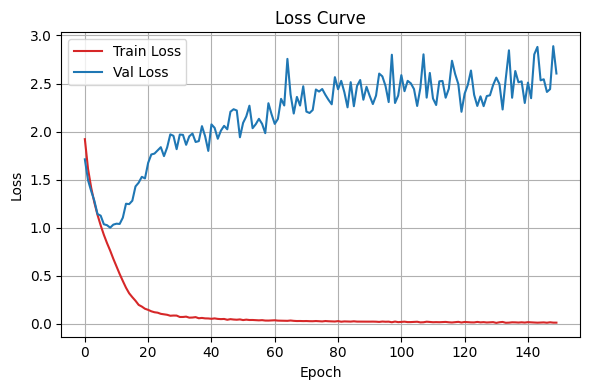

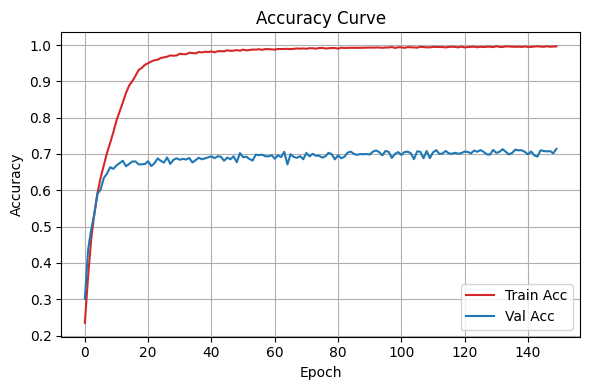

In [ ]:

LEARNING_RATE_DEFAULT = 1e-4
BATCH_SIZE_DEFAULT = 32
MAX_EPOCHS_DEFAULT = 150
EVAL_FREQ_DEFAULT = 1
OPTIMIZER_DEFAULT = 'ADAM'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model     = CNN(n_channels=3, n_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE_DEFAULT)
history = train(model, train_loader, val_loader,
                optimizer, criterion, device,
                max_epochs=MAX_EPOCHS_DEFAULT, eval_freq=EVAL_FREQ_DEFAULT)
plot_curve(history)
# 1. 损失曲线
